<a href="https://colab.research.google.com/github/AnIsAsPe/Aprendizaje-por-Refuerzo/blob/main/Notebooks/Gesti%C3%B3n_de_una_red_el%C3%A9ctrica_Aprendizaje_por_refuerzo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# El Problema

## Red eléctirca "El Espino"

---
![microgrid Espino](https://ars.els-cdn.com/content/image/1-s2.0-S0360544219317682-gr4.jpg)

---

**Objetivo:**

 Optimizar el ***costo*** de la red frente a la incertidumbre de la generación de energía solar y de la demanda de energía

**Alternativas:**

1. Operar la red con reglas:

    - Priorizar consumo de la energía solar
    - Si la generación fotovoltaica es mayor que la demanda, se carga la batería
    - Si la energía solar no alcanza a satisfacer el consumo, se descarrga la batería hasta que alcance el 50% de la carga
    - Si la energía solar y la batería no alcanzan a satisfacer la demanda, se prende el generador de gas
    - El generador carga la batería si la demanda es menor que la generación minima de operación.

2. Aprender una ***política*** para decidir una acciones dado un estado

Necesitamos definir las ***acciones posibles*** y los ***estados posibles*** y realizar un proceso de aprendizaje de la política

## Estados, acciones, recompensa/pérdida

**Acciones posibles:**

- Generar energía con gas
- Descargar batería para usar energía almacenada
- Cargar batería (almacenar exceso de energía)

**Estados posibles:**

- Demanda Neta:  Demanda de energía - Generación de energía solar
- Estado de carga de la Batería


**Recompensa/pérdida**
- Costo de generación de electricidad

# Bibliotecas

[pymgrid](https://github.com/Total-RD/pymgrid)


In [1]:
!pip install git+https://github.com/Total-RD/pymgrid/

  Cloning https://github.com/Total-RD/pymgrid/ to /tmp/pip-req-build-qhcr8nek
  Running command git clone -q https://github.com/Total-RD/pymgrid/ /tmp/pip-req-build-qhcr8nek
  Created wheel for pymgrid: filename=pymgrid-0.1.0-py3-none-any.whl size=3423644 sha256=08ce0e2c7c2bbc393ed1328bffb262a49e4cd9e8dcbf2a87a7ee58e0c3aa0e68
  Stored in directory: /tmp/pip-ephem-wheel-cache-csg1bowt/wheels/e5/88/1d/f8d379259639fcb7a25a36c96e2f63e402ce354dde5ece9ce6
Successfully built pymgrid


In [2]:

from pymgrid import MicrogridGenerator as mg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import time
import sys

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Ambiente: 
* Arquitectura de la microrred 
* Datos históricos de demanda energética y generación solar
* Componentes de la red

### Arquitectura de la microrred

In [3]:
# seleccionamos un ambiente con un arquitectura conveniente para nuestro problema
env = mg.MicrogridGenerator(nb_microgrid=33,  
                            random_seed = 7   # el tamaño de los componente de la red es asignado aleatoriamente
                            ) 
env.generate_microgrid(verbose=False)  

red = env.microgrids[32]
print('Arquitecturade la red: \n',red.architecture)

Arquitecturade la red: 
 {'PV': 1, 'battery': 1, 'genset': 1, 'grid': 0}


In [4]:
 red.print_info()

Microgrid parameters


,load,cost_loss_load,cost_overgeneration,cost_co2,PV_rated_power,battery_soc_0,battery_power_charge,battery_power_discharge,battery_capacity,battery_efficiency,battery_soc_min,battery_soc_max,battery_cost_cycle,genset_polynom_order,genset_polynom_0,genset_polynom_1,genset_polynom_2,genset_rated_power,genset_pmin,genset_pmax,fuel_cost,genset_co2
0,1392,10,1,0.1,1879.2,0.2,574,574,2295,0.9,0.2,1,0.02,3,1.442031,0.547353,0.025381,1547,0.05,0.9,0.4,2


Architecture:
{'PV': 1, 'battery': 1, 'genset': 1, 'grid': 0}
Actions: 
dict_keys(['load', 'pv_consummed', 'pv_curtailed', 'pv', 'battery_charge', 'battery_discharge', 'genset'])
Control dictionnary:
['load', 'pv_consummed', 'pv_curtailed', 'pv', 'battery_charge', 'battery_discharge', 'genset']
Status: 
dict_keys(['load', 'hour', 'pv', 'battery_soc', 'capa_to_charge', 'capa_to_discharge'])
Has run mpc baseline:
False
Has run rule based baseline:
False


Cada acción(`Action`) que se aplique a la red será definida por los valores que se pasen a cada una de las claves del diccionario de control.
Cuando se aplique la acción, entonces obtendremos un `Status` nuevo.

### Datos históricos de demanda energética y generación sola

Cada observación es una hora y la longitud de la serie es de un año (8769 horas)

In [5]:
red.print_load_pv()

Load


PV


## Características de los componentes


**Demanda**

In [6]:
 # Variable aleatoria en función del tiempo
red.load  

221.48413295528024

**Generación fotovoltaica (pv)**

In [7]:
# variable aleatoria en función del tiempo
red.pv

0.0

**Batería**

In [8]:
## Costante. Cantidad de energía máxima que puede cargar la batería en una hora
red.battery.p_charge_max


574

In [9]:
# Constante. Cantidad de energía máxima que puede descargar la batería en una hora
red.battery.p_discharge_max

574

In [10]:
# Constante. Estado de carga máxima
red.battery.soc_max

1

In [11]:
# Constante. Estado de carga mínima
red.battery.soc_min

0.2

In [12]:
# Variable. Estado de la carga
red.battery.soc

0.2

In [13]:
# Variable dependiente de soc. Cantidad de energía que la batería puede cargar antes de tener carga completa
red.battery.capa_to_charge  

2040.0

In [14]:
# Variable dependiente de soc. Cantidad de energía disponible antes de estar totalmente descargada
red.battery.capa_to_discharge  

0.0

**Generador de combustibles fósiles (genset)**

In [21]:
# Características del generador
print('Costo del combustible por KWh: ${:0.2f} '.format(red.genset.fuel_cost))
print('Potencia máxima en KW: ', red.genset.rated_power )
print('Operación mínima y máxima: {}%, {}%'.format(red.genset.p_min,
                                                         red.genset.p_max))

Costo del combustible por KWh: $0.40 
Potencia máxima en KW:  1547
Operación mínima y máxima: 0.05%, 0.9%


Con los valores anteriores podemos calcular la potencia en KW máxima y mínima de operación

In [22]:
gen_min = red.genset.p_min * red.genset.rated_power  #potencia mínima del generador
gen_max = red.genset.p_max * red.genset.rated_power  #potencia maxima del generador
gen_min, gen_max

(77.35000000000001, 1392.3)

## Diccionario de control para interactuar con la red

La función `run()` necesita un diccionatrio de control que depende de la arquitectura de nuestra red,  con el que indicaremos las acciones en cada momento.


In [ ]:
# Los campos que se pueden usar en el diccionario de control de nuestra red para establecer las acciones son:
red.get_control_dict() 

['load',
 'pv_consummed',
 'pv_curtailed',
 'pv',
 'battery_charge',
 'battery_discharge',
 'genset']

`load` y `pv`, se cargan automáticamente.

Nosotros nos concentraremos en si se carga la batería, si se descarga o si se genera energía con fuentes fósiles


In [ ]:
red.reset()  # Reiniciamos la red
demanda_neta = red.load - red.pv

print('Estado_t0: ({}, {})'.format(demanda_neta, red.battery.soc))

Estado_t0: (221.48413295528024, 0.2)


In [ ]:
demanda_neta = red.load - red.pv
print('Estado: ({}, {})\n'.format(demanda_neta, red.battery.soc))

#con los valores del diccionario vamos a establecer la acción a tomar
accion = {
            'pv_consumed': 0,
            'battery_charge': 352,
            'battery_discharge':0,
            'genset': 0
          }

red.run(accion)    # Nos regresa un diccionario con un nuevo estatus.


Estado: (221.48413295528024, 0.2)



{'battery_soc': 0.3380392156862745,
 'capa_to_charge': 1688.0,
 'capa_to_discharge': 285.11999999999995,
 'hour': 0,
 'load': 217.51072938340025,
 'pv': 0.0}

Corre las dos celdas de código varias veces y observa los resultados

#  Estados

Cada estado del entorno se determina por dos variables:

- Demanda Neta:  Demanda de energía - Generación de energía solar
- Estado de carga de la batería

In [23]:
demanda_neta = red.load - red.pv
demanda_neta

221.48413295528024

In [24]:
red.battery.soc

0.2

In [25]:
# Estado actual
demanda_neta = red.load - red.pv
demanda_neta, red.battery.soc

(221.48413295528024, 0.2)

# Definición de las acciones

* accion 0: cargar batería
* accion 1: descargar batería
* acción 2: generación no renovable (genset)

In [29]:
def actions_agent(accion):
    '''  Crea el diccionario para interactuar con la red según la acción tomada:
    0: Cargar batería. La energía a cargar, depende de las variables de estado
    1: Descargar batería.
    2.: Generar energía no renovable (genset).

    Para cualquier de estas acciones es necesario identificar cuanta energía esta
    disponible o cuánta se está demandando a la red, a través de la demanda neta; 
    Además es necesario evaluar cuánta energía puede cargarse o descargarse al 
    momento de la acción.
    '''
       
    demanda_neta =  red.load - red.pv                 
    # Energía que se puede cargar en la batería:    
    p_charge = max(0,    # Debe ser mayor a cero
                   min(-demanda_neta + gen_min,    # energía disponible, en el tiempo t
                       red.battery.capa_to_charge, # energía por cargar, antes de tener carga máxima, en el tiempo t
                       red.battery.p_charge_max    # energía que puede cargarse por hora
                       )
                   ) 

    # Energía que se puede descargar de la batería
    p_discharge = max(
                      0,
                      min(
                          demanda_neta-gen_min,   # energía faltante para cubrir la demanda, en el tiempo t
                          red.battery.capa_to_discharge, # energía disponible, antes de tener carga mínima, en el tiempo t
                          red.battery.p_discharge_max  #  energía que puede descargarse en una hora
                          )
                      ) 

    control_dic ={}
    if accion == 0:   # Cargar batería
        control_dict= {'pv_consumed': min(red.pv, red.load),
                       'pv_curtailed':0,
                       'battery_charge': p_charge,
                       'battery_discharge': 0,
                       'genset': gen_min
                       }
    elif accion == 1:   # Descargar bateria
        control_dict = {'pv_consummed': min(red.pv, red.load),
                        'pv_curtailed':0,
                        'battery_charge': 0,
                        'battery_discharge': p_discharge,
                        'genset': gen_min
                        }
   
    elif accion == 2:  #Generación no renovable (genset)
      
        control_dict = {'pv_consummed': min(red.pv, red.load),
                        'pv_curtailed':0,
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'genset': max(gen_min, 
                                      min(gen_max, red.load - min(red.pv, red.load)))
                       }
    return control_dict

In [63]:
#red.reset()  # reiniciar el entorno
print('** Tiempo t **:')
print('load: {0:.2f}, pv: {1:.1f}, battery_soc: {2:.1f}'.format(red.load, red.pv, red.battery.soc))

# Elegir una acción
accion = 0
dict_control = actions_agent(accion)

# Interactuar con la red con la acción elegida
red.run(dict_control)
print('\nDiccionario para interactuar con la red:\n',dict_control)

print('\n** Tiempo t+1 **:')
print('load: {0:.2f}, pv: {1:.1f}, battery_soc: {2:.1f}'.format(red.load, red.pv, red.battery.soc))
print('\nCOSTO DE LA ACCIÓN: ${:.2f} '.format(red.get_cost())) 

** Tiempo t **:
load: 194.54, pv: 442.6, battery_soc: 0.5

Diccionario para interactuar con la red:
 {'pv_consumed': 194.5412742049943, 'pv_curtailed': 0, 'battery_charge': 325.38666972023935, 'battery_discharge': 0, 'genset': 77.35000000000001, 'load': 194.5412742049943, 'pv': 442.5779439252336, 'loss_load': 0, 'overgeneration': 0, 'pv_consummed': 0}

** Tiempo t+1 **:
load: 198.13, pv: 374.1, battery_soc: 0.7

COSTO DE LA ACCIÓN: $52.92 


# Inicializa la tabla con la política Q 

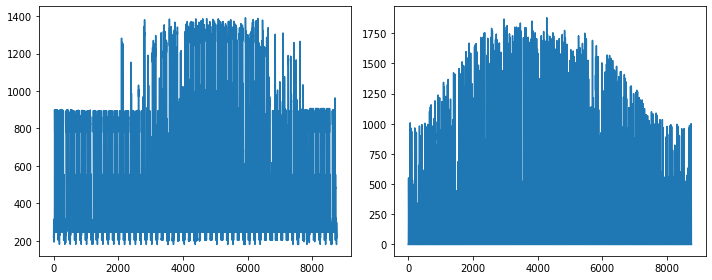

In [25]:
red.set_horizon(9000)   # se pueden hacer predicciones hasta por un año: 8769 horas
demanda_neta = red.forecast_load() - red.forecast_pv() 

fig, axs= plt.subplots(1,2, figsize = (10, 4), tight_layout = True)
for s, ax in zip([red.forecast_load(), red.forecast_pv()] , axs):
  ax.plot(s)

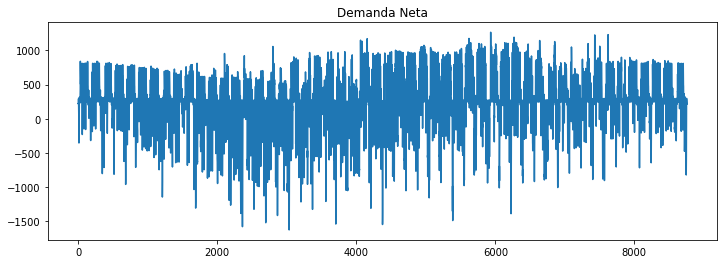

In [26]:
pd.Series(demanda_neta).plot(title='Demanda Neta', figsize=(12,4))
plt.show()

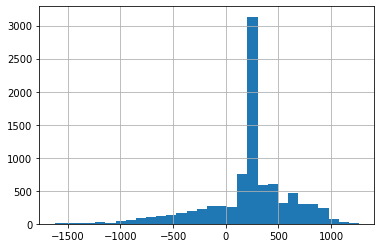

In [27]:
pd.Series(demanda_neta).hist(bins=30)
plt.show()

In [28]:
pd.Series(demanda_neta).describe()

count    8758.000000
mean      231.267318
std       399.780127
min     -1623.563656
25%       186.967705
50%       255.946035
75%       434.290712
max      1265.549159
dtype: float64

In [67]:
demanda_neta = red.load - red.pv
demanda_neta, red.battery.soc

(-175.95070229537848, 0.662785440246684)

In [66]:
# Discretizaremos los valores de estados 
demanda_neta = int((red.load - red.pv)//10 *10)
soc = round(red.battery.soc,1)
demanda_neta, soc

(-180, 0.7)

In [39]:
def init_qtable(red, acciones_posibles):

    # Demanda neta en un horizonte de un año
    red.set_horizon(9000)
    demanda_neta = red.forecast_load() - red.forecast_pv()
    posible_demanda_min = demanda_neta.min() - 1 * demanda_neta.std()
    posible_demanda_max = demanda_neta.max() + 1 * demanda_neta.std()

    #creamos una lista que guardará todas las combinaciones de demanda_neta y estado de la batería
    state = []  
    for d_n in range(int(posible_demanda_min//10),int(posible_demanda_max//10)):  #ciclo entre la demanda neta minima y máxima DISCRETIZADA    
        for soc in np.arange(red.battery.soc_min, red.battery.soc_max + 0.1, 0.1):  #ciclo entre el estado de carga de la batería minima y máxima  DISCRETIZADO
            soc = round(soc, 1)
            state.append((d_n*10, soc))            
    Q={}
    #Iniciamos el estado Q(s,a) en cero
    for s in state:
        Q[s] = {}                            
        for a in range(acciones_posibles):
            Q[s][a] = 0

    return Q

In [40]:
Q = init_qtable(red, 3)
print('Total de estados posibles:',len(Q))  

Total de estados posibles: 3321


In [69]:
s = 220, 0.2
Q[s] # Para cada estado tenemos un diccionario donde se actualizará el valor para cada acción

{0: 0, 1: 0, 2: 0}

# Entrenamiento del agente

El agente aprenderá de las acciones tomadas en cada estado y de los costos ocasionados por esas acciones

## Funciones auxiliares para el entrenamiento del agente

In [73]:
def reitera_o_cambia_accion_edg(accion, ε, acciones_posibles): 
  '''Reitera o elige nueva acción, implementando la estrategia epsilon decreasing
  gready.
     accion: acción escogida previamente
     ε: valor actual de epsilon
     acciones_posibles
  '''
  p = np.random.uniform(1.0, 0.0 )
  if p < (1 - ε):
        # cuándo epsilon es grande se sigue con la misma acción (Explotación)
        return accion   # sigue con la misma acción 
  else: 
        # cuando es pequeño, se escoge una al azar (Exploración)
        return np.random.choice(acciones_posibles)    

In [74]:
def max_dict(Qs):
    '''Devuelve la calve del diccionario que tenga el valor máximo'''
    a = max(Qs, key = Qs.get)
    return a

In [75]:
def print_welcome(idx):
    
    if idx == 0:
        print("------------------------------------")
        print("|             WELCOME              |")
        print("------------------------------------")
    elif idx == 1:
        
        print("t -     STATE  -  ACTION - COST")
        print("================================")
    

---
## Función de entrenamiento del Agente
###Actualización de la política Q
---

$Q(S_t,A_t) \leftarrow Q(s_t,A_t) + \alpha\left[R_{t+1} + \gamma \max_a {Q(S_{t+1},a)}-Q(S_t,A_t)\right]$

In [71]:
def training_Q_Learning(mg, horizon, episodios):
    ''' 
    mg: microred,
    horizon: horizonte en horas de cada simulación
    episodios: número de simulaciones para aprender  '''

    acciones_posibles = 3                     
    Q = init_qtable(mg, acciones_posibles)    # inicializar tabla de estados                              # 
    vector_ε = np.exp(-5*np.linspace(0,1, episodios))              

    
    record_cost = []     # función de pérdida

    print_training = "Training Progressing .   "
    print_welcome(0)  
    print("\n")
    
    
    for episodio in range(episodios+1):  
            #### Control del progreso del entrenamiento   #############################
            if episodio == 0:
                value_print="\rEpisode " + str(episodio) +"/" + str(episodios)   
                sys.stdout.write(value_print)   # guarda en buffer datos a imprimir 
                sys.stdout.flush( )             # forza al buffer a imprimir todo en la términal
                
            elif episodio % 10 == 0:       
                if print_training == "Progreso del entrenamiento .   ":                
                    print_training = "Progreso del entrenamiento ..  "                
                elif print_training == "Progreso del entrenamiento ..  ":            
                    print_training = "Progreso del entrenamiento ...  "           
                else:            
                    print_training = "Progreso del entrenamiento .   "

            value_print="\r"+ print_training +"Episode " + str(episodio) +"/" + str(episodios)  
            sys.stdout.write(value_print) 
            sys.stdout.flush()   
            ###########################################################################    
            episode_cost = 0                 
            mg.reset()
            ε = vector_ε[episodio-1]
        
            #  Identifica el estado inicial
            demanda_neta = int((mg.load - mg.pv)//10 *10)
            soc = round(mg.battery.soc, 1)
            s = (demanda_neta, soc)        #estado

            # Elige la accion con el valor más grande del diccionario Q para el estado s
            a = max_dict(Q[s])
            # se decide si se continua con la acción elegida (a) o se escoge nuevamente de forma aleatoria   
            a = reitera_o_cambia_accion_edg(a, ε, acciones_posibles)

            for i in range (horizon):
            
                    # Se ejecuta la acción 
                    action = actions_agent(a)        
                    mg.run(action)   

                    # Se obtiene el costo de la acción y se suma al costo del episodio
                    r = -mg.get_cost()                
                    episode_cost += mg.get_cost()     

                    # Se guarda el nuevo estado 
                    demanda_neta = int((mg.load - mg.pv)//10 *10)
                    soc = round(mg.battery.soc,1)
                    s_ = (demanda_neta, soc)             

                    # Se elige nuevamente una acción para ese estado
                    a_ = max_dict(Q[s_])
                    a_ = reitera_o_cambia_accion_edg(a_, ε, acciones_posibles)
                    
                    # ACTUALIZA Q
                    alpha = 0.1    # taza de aprendizaje (learning rate)
                    gamma = 0.99    
                    if i == horizon-1:                  
                        Q[s][a] += alpha*(r - Q[s][a])         
                    else:             
                        old_Q = Q[s][a]
                        target = r + gamma*Q[s_][a_]
                        td_error = target - old_Q
                        Q[s][a] = (1-alpha) * Q[s][a] + alpha * td_error

                    #actualiza valores de estado y acción para seguir el ciclo
                    s, a = s_, a_ 
    
    return Q

In [76]:
 %time  Q1 = training_Q_Learning(red, horizon=4000, episodios=500)

------------------------------------
|             WELCOME              |
------------------------------------


Progreso del entrenamiento ..  Episode 500/500CPU times: user 11min 24s, sys: 1.42 s, total: 11min 25s
Wall time: 11min 27s


In [77]:
Q1_table = pd.DataFrame.from_dict(Q1, orient='index' )
Q1_table.columns=['accion_0', 'accion_1','accion_2']

In [92]:
#Q1_table.to_dict()

In [78]:
Q1_table[(Q1_table != 0).any(axis=1)]

accion_0     accion_1     accion_2
-1630 0.3  -134.926920     0.000000     0.000000
      0.4     0.000000     0.000000  -174.732366
      0.5  -527.007111  -496.198492  -524.211523
      0.6  -826.897419  -865.916379  -918.695028
      0.7 -1023.138897  -995.792215 -1062.683285
...                ...          ...          ...
 1050 0.4 -3468.562183 -2623.642256  -653.187995
      0.5  -984.576371 -1928.273345  -689.807818
      0.6  -984.576371     0.000000   -63.437122
      0.7  -984.576371     0.000000     0.000000
      0.9  -984.576371     0.000000     0.000000

[2093 rows x 3 columns]

In [80]:
# # Guardar Política en archivo csv 
# Q1_table.to_csv('/content/drive/MyDrive/Politica_red.csv')

In [97]:
# # Leer política en archivo csv
# Q1_table = pd.read_csv('/content/drive/MyDrive/Politica_red.csv', index_col =[0,1])
# Q1 = Q1_table.to_dict()


# Prueba de la red operando con la política aprendida

In [86]:
def testing_Q_Learning(mg, Q, horizon):
    
    mg.reset()
    #  Identifica el estado inicial
    demanda_neta = int((mg.load - mg.pv)//10 *10)
    soc = round(mg.battery.soc,1)
    s = (demanda_neta, soc)

    # Elige la accion con el valor más grande del diccionario Q para el estado s
    a = max_dict(Q[s])
   
    # Se inicializa la variable de costo para horizonte definido
    total_cost = 0 
    print_welcome(1)
    nombre_accion = {0:'carga batería', 1: 'descarga batería', 2:'generación fósil'}
    for i in range (horizon):        
        # Se ejecuta la acción 
        action = actions_agent(a)
        mg.run(action)

        # Se obtiene el costo de la acción y se suma al costo total
        r = mg.get_cost()
        total_cost += r

        # Se imprime el estado de la red, la acción tomada y el costo generado
        if i < 10:
            print(i," -",(int(demanda_neta),soc),nombre_accion[a],"$",round(total_cost,1))
        else:
            print(i,"-",(int(demanda_neta),soc),nombre_accion[a],"$",round(total_cost,1))
        
        # Se calculan los valores del siguiente estado 
        demanda_neta = int((mg.load - mg.pv)//10 *10)
        soc = round(mg.battery.soc,1)
        s_ = (demanda_neta, soc)

        # Se obtiene la acción con menor costo en el estado s_
        a_ = max_dict(Q[s_])

        # se actualizan los valores de s y a
        s, a = s_, a_  

In [87]:
testing_Q_Learning(red ,Q1, 4000)

t -     STATE  -  ACTION - COST
0  - (220, 0.2) generación fósil $ 132.9
1  - (210, 0.2) generación fósil $ 263.4
2  - (220, 0.2) generación fósil $ 396.1
3  - (210, 0.2) generación fósil $ 526.6
4  - (230, 0.2) generación fósil $ 665.6
5  - (240, 0.2) generación fósil $ 814.8
6  - (290, 0.2) generación fósil $ 991.3
7  - (240, 0.2) generación fósil $ 1139.4
8  - (160, 0.2) generación fósil $ 1241.1
9  - (70, 0.2) descarga batería $ 1313.8
10 - (-20, 0.2) carga batería $ 1362.0
11 - (-260, 0.2) carga batería $ 1415.1
12 - (-360, 0.4) carga batería $ 1470.1
13 - (-250, 0.5) carga batería $ 1523.0
14 - (-180, 0.7) carga batería $ 1574.5
15 - (-90, 0.8) carga batería $ 1624.2
16 - (180, 0.8) descarga batería $ 1672.8
17 - (310, 0.8) descarga batería $ 1723.9
18 - (310, 0.7) generación fósil $ 1912.8
19 - (290, 0.7) descarga batería $ 1963.5
20 - (290, 0.6) descarga batería $ 2014.3
21 - (270, 0.5) descarga batería $ 2064.6
22 - (250, 0.4) descarga batería $ 2114.5
23 - (220, 0.3) descarga

### Comparar el desempeño cuando se aumenta la politica variando el número de episodios 

In [88]:
 %time  Q2 = training_Q_Learning(red, horizon=4000, episodios=10)

------------------------------------
|             WELCOME              |
------------------------------------


Progreso del entrenamiento .   Episode 10/10CPU times: user 15.2 s, sys: 46 ms, total: 15.3 s
Wall time: 15.3 s


In [89]:
# Con la política con solo 100 episodios
testing_Q_Learning(red,Q2, 4000)

t -     STATE  -  ACTION - COST
0  - (220, 0.2) generación fósil $ 132.9
1  - (210, 0.2) generación fósil $ 263.4
2  - (220, 0.2) generación fósil $ 396.1
3  - (210, 0.2) generación fósil $ 526.6
4  - (230, 0.2) generación fósil $ 665.6
5  - (240, 0.2) generación fósil $ 814.8
6  - (290, 0.2) generación fósil $ 991.3
7  - (240, 0.2) generación fósil $ 1139.4
8  - (160, 0.2) generación fósil $ 1241.1
9  - (70, 0.2) descarga batería $ 1313.8
10 - (-20, 0.2) carga batería $ 1362.0
11 - (-260, 0.2) carga batería $ 1415.1
12 - (-360, 0.4) carga batería $ 1470.1
13 - (-250, 0.5) carga batería $ 1523.0
14 - (-180, 0.7) carga batería $ 1574.5
15 - (-90, 0.8) carga batería $ 1624.2
16 - (180, 0.8) descarga batería $ 1672.8
17 - (310, 0.8) descarga batería $ 1723.9
18 - (310, 0.7) descarga batería $ 1775.0
19 - (290, 0.5) generación fósil $ 1949.3
20 - (290, 0.5) generación fósil $ 2126.7
21 - (270, 0.5) descarga batería $ 2177.0
22 - (250, 0.5) descarga batería $ 2226.9
23 - (220, 0.4) descarga